In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Read the CSV
df = pd.read_csv("../results/ImageNet_disentanglement_regression.csv")

In [ ]:
plt.rcParams.update(
    {
        "font.family": "serif",
        "font.serif": ["Times New Roman", "Times", "DejaVu Serif"],
        "font.size": 8,
        "figure.dpi": 300,  # Set display DPI
        "savefig.dpi": 300,  # Set save DPI
    }
)

/var/folders/22/gl3hkfn11y99h_1cyk_cn3fw0000gn/T/ipykernel_37443/4041437593.py:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["intensity"] = intensities
/var/folders/22/gl3hkfn11y99h_1cyk_cn3fw0000gn/T/ipykernel_37443/4041437593.py:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["intensity"] = intensities
/var/folders/22/gl3hkfn11y99h_1cyk_cn3fw0000gn/T/ipykernel_37443/4041437593.py:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[

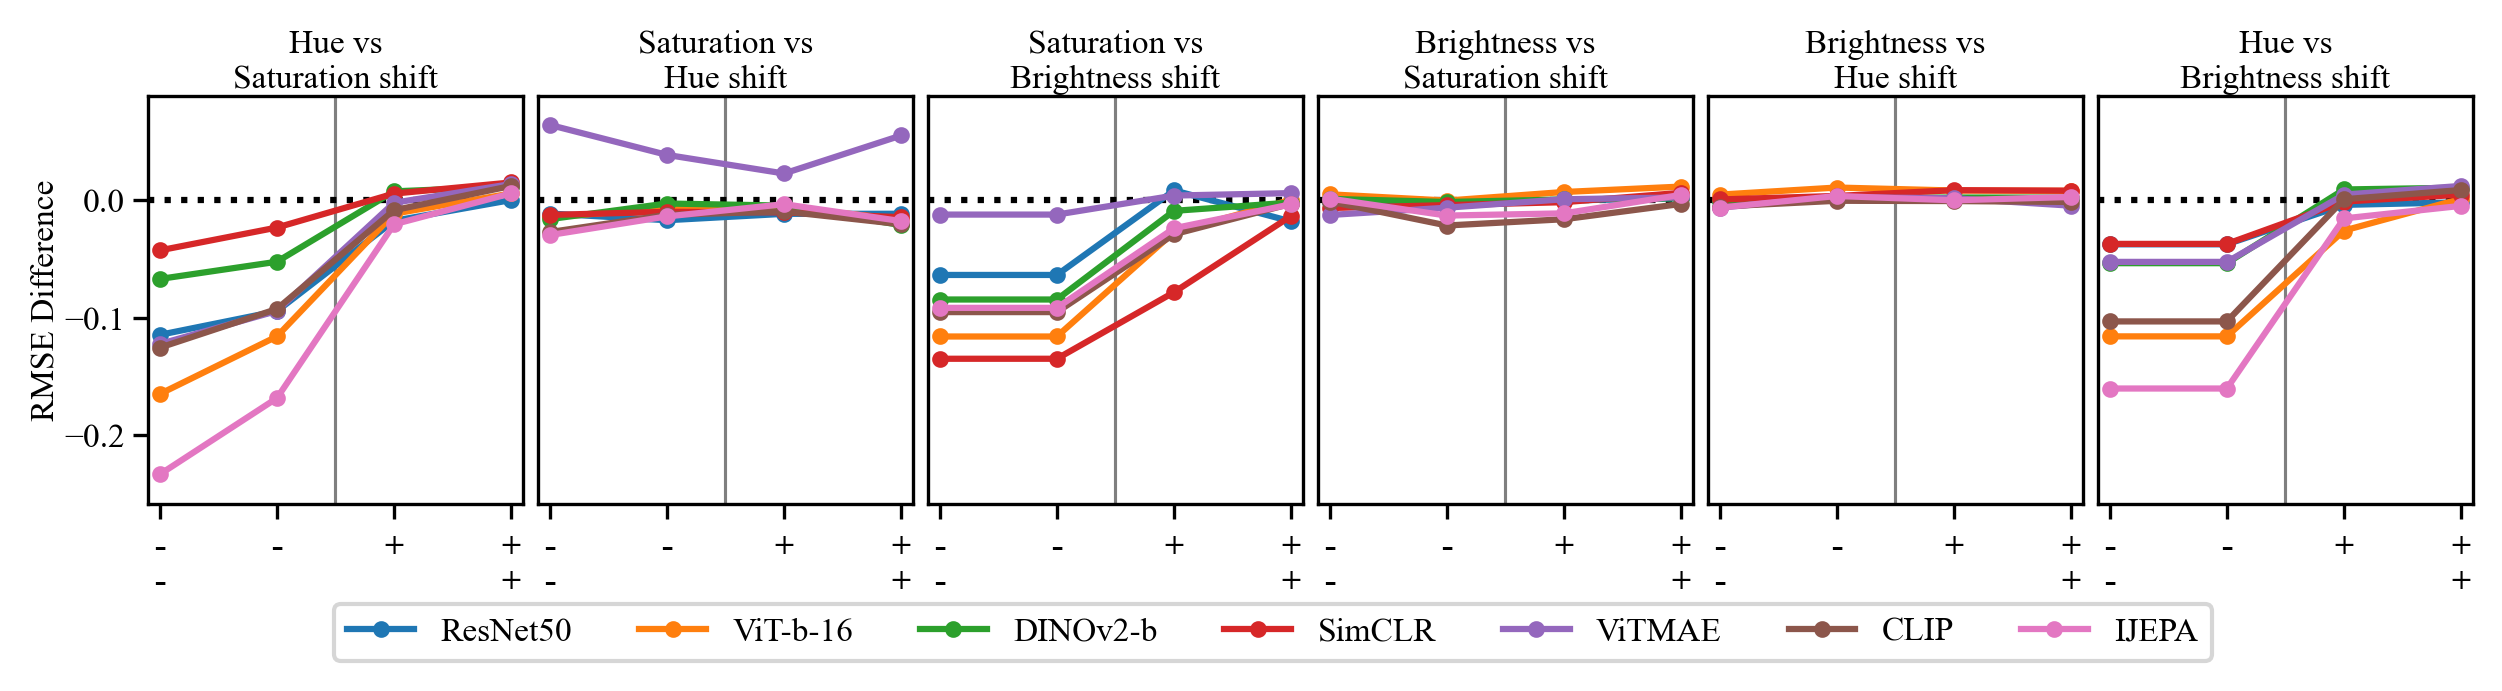

In [141]:
import matplotlib.pyplot as plt
import numpy as np


def plot_model_comparisons(df, models=None):
    # Get unique models (strip _ImageNet suffix)
    if not models:
        models = [
            "ResNet18_ImageNet",
            "ResNet34_ImageNet",
            "ResNet50_ImageNet",
            "ResNet101_ImageNet",
            "ViT_b_16_ImageNet",
            "ViT_l_16_ImageNet",
            "ViT_b_32_ImageNet",
            "ViT_l_32_ImageNet",
            "DINOv2_small",
            "DINOv2_base",
            "DINOv2_large",
            "DINO",
            "SimCLR",
            "ViT_MAE",
            "CLIP",
            "IJEPA",
        ]

    # Format display names
    display_names = {
        model: model.replace("_ImageNet", "")
        .replace("small", "s")
        .replace("base", "b")
        .replace("large", "l")
        .replace("ViT_MAE", "ViTMAE")
        .replace("_", "-")
        for model in models
    }

    # Setup plot grid
    fig, axes = plt.subplots(
        1, 6, figsize=(10, 2), sharey=True
    )  # Adjusted for 1 row, 6 columns, shared y-axis
    plt.subplots_adjust(
        hspace=0, wspace=0.04, bottom=0.2
    )  # Adjust bottom for legend space

    # Dictionary to store legend handles
    legend_elements = {}

    # Plot each factor combination
    plot_order = [
        ("hue", "saturation"),
        ("saturation", "hue"),
        ("saturation", "brightness"),
        ("brightness", "saturation"),
        ("brightness", "hue"),
        ("hue", "brightness"),
    ]

    # Find global y-axis limits
    y_min = float("inf")
    y_max = float("-inf")

    # First pass to find global y limits
    for factor1, factor2 in plot_order:
        for model in models:
            model_data = df[df["run_name"].str.contains(model)]
            transform = f"{factor2.capitalize()}Shift"
            data = model_data[
                (model_data["label"] == factor1)
                & (model_data["transform"].str.contains(transform))
            ]

            if not data.empty:
                y_min = min(y_min, data["diff_rmse"].min())
                y_max = max(y_max, data["diff_rmse"].max())

    # Add some padding to the limits
    y_range = y_max - y_min
    y_min -= y_range * 0.05
    y_max += y_range * 0.05

    # Main plotting loop
    for i, (factor1, factor2) in enumerate(plot_order):
        ax = axes[i]  # Access axes directly using index i
        ax.axhline(y=0, color="black", linestyle=":", alpha=1, linewidth=1.5)

        for k, model in enumerate(models):
            model_data = df[df["run_name"].str.contains(model)]
            transform = f"{factor2.capitalize()}Shift"
            data = model_data[
                (model_data["label"] == factor1)
                & (model_data["transform"].str.contains(transform))
            ]

            intensities = [int(t.replace(transform, "")) for t in data["transform"]]
            data["intensity"] = intensities
            data = data.sort_values("intensity")

            intensity_mapping = {
                25: "-\n-",
                50: "-",
                75: "+",
                100: "+\n+",
            }

            x_data = [intensity_mapping[i] for i in data["intensity"]]
            y_data = data["diff_rmse"].values
            ax.set_ylim([y_min, y_max])  # Set shared y-axis limits
            line = ax.plot(x_data, y_data, marker=".")

            if model not in legend_elements:
                legend_elements[display_names[model]] = line[0]

        ax.set_title(
            f"{factor1.capitalize()} vs\n{factor2.capitalize()} shift",
            fontsize=8,
            pad=2,  # Reduced padding
        )
        ax.tick_params(axis="x", rotation=0)
        # Make x-ticks bold
        ax.set_xticklabels(ax.get_xticklabels(), weight="extra bold")

        # Remove y-label and ticks for all but the leftmost plot
        if i > 0:
            ax.set_ylabel("")
            ax.tick_params(axis="y", which="both", left=False, labelleft=False)
        else:
            ax.set_ylabel(
                "RMSE Difference", labelpad=1
            )  # Reduced distance between label and ticks
            ax.tick_params(
                axis="y", which="major", pad=2
            )  # Bring y tick labels closer to the axis

        ax.axvline(
            x=1.5, color="black", linestyle="-", alpha=0.5, linewidth=0.75, zorder=0
        )  # Add a vertical line in the middle behind the plots
        ax.set_ylim([y_min - 0.01, y_max + 0.01])  # Set shared y-axis limits
        ax.set_xlim([-0.1, 3.1])

    # Add legend with formatted names below the plots
    fig.legend(
        legend_elements.values(),
        legend_elements.keys(),
        loc="lower center",
        bbox_to_anchor=(0.5, -0.09),  # Adjust vertical position
        ncol=len(models),  # Arrange in a single row
    )
    plt.show()


plot_model_comparisons(
    df,
    models=[
        "ResNet50_ImageNet",
        "ViT_b_16_ImageNet",
        "DINOv2_base",
        "SimCLR",
        "ViT_MAE",
        "CLIP",
        "IJEPA",
    ],
)

/var/folders/22/gl3hkfn11y99h_1cyk_cn3fw0000gn/T/ipykernel_37443/2290886130.py:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["intensity"] = intensities
/var/folders/22/gl3hkfn11y99h_1cyk_cn3fw0000gn/T/ipykernel_37443/2290886130.py:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["intensity"] = intensities
/var/folders/22/gl3hkfn11y99h_1cyk_cn3fw0000gn/T/ipykernel_37443/2290886130.py:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[

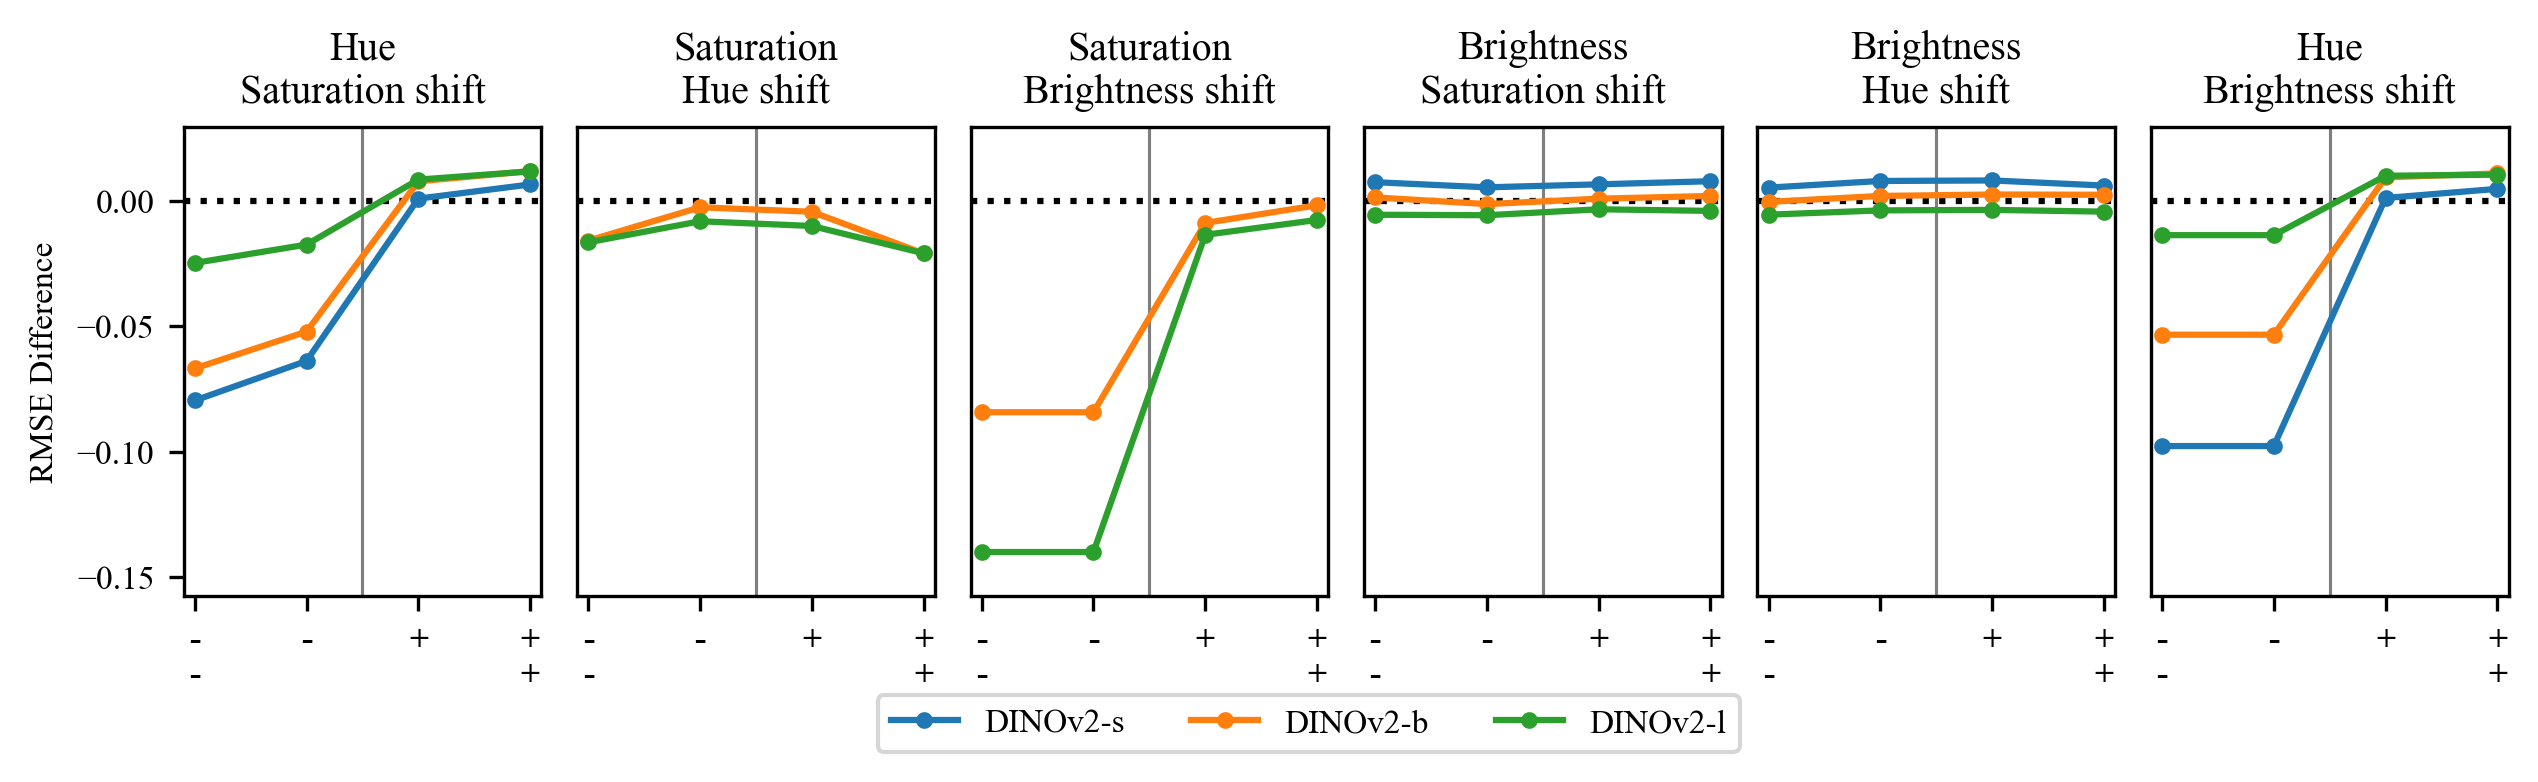

In [ ]:
plot_model_comparisons(
    df,
    models=[
        # "ResNet18_ImageNet",
        # "ResNet34_ImageNet",
        # "ResNet50_ImageNet",
        # "ResNet101_ImageNet",
        # "ViT_b_16_ImageNet",
        # "ViT_l_16_ImageNet",
        # "ViT_b_32_ImageNet",
        # "ViT_l_32_ImageNet",
        "DINOv2_small",
        "DINOv2_base",
        "DINOv2_large",
        # "DINO",
    ],
)